In [1]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from astropy.modeling.functional_models import Gaussian2D
from astropy.nddata import CCDData
from photutils.psf import IntegratedGaussianPRF
from matplotlib import pyplot as plt

np.random.seed(123)
top = Path('tmp')
top.mkdir(exist_ok=True)
final_image = np.zeros((50, 100))
bias_adu = 1000      # ADU
sens_center_xy = (90, 30)
sens_sigma = 100     # pixel 
dark_epsec = 0.1     # epsec = e/sec = electron per second (per pixel)
exptime = 300        # seconds
gain_epadu = 1.36    # epadu = e/ADU = electron per ADU
rdnoise_e = 9.0      # electrons
seeing_arcsec = 2.5  # arcsec (FWHM)
pixel_scale = 0.9    # arcsec per pixel
skylevel_e = 500     # electrons

# Stars' properties. 
#   Flux = integrated flux in electrons, 
#   x_0/y_0 = center positions in pixel
stars_props = dict(A=dict(flux=70000, x_0=40, y_0=20),
                   B=dict(flux=30000, x_0=30, y_0=10),
                   C=dict(flux=10000, x_0=70, y_0=30)
                   )

def add_rdnoise(image_adu, rdnoise_e, gain_epadu):
    ''' Adds readnoise
    Parameters
    ----------
    image_adu : array-like
        The image to add readnoise, in ADU unit.
    rdnoise_e, gain_epadu : float
        The readnoise and gain in electrons and electrons per ADU, respectively.

    Return
    ------
    _result : ndarray
        The noise-added image.
    '''
    rdnoise = np.random.normal(loc=0, scale=rdnoise_e, size=image_adu.shape)
    _result = image_adu + rdnoise / gain_epadu
    return _result

# Below codes are composed with first cell the answer of problem is in and second cell printng out the results of first cell, if showing is needed.

# 1

In [2]:
bias = np.ones_like(final_image)*bias_adu

In [3]:
print(bias)

[[1000. 1000. 1000. ... 1000. 1000. 1000.]
 [1000. 1000. 1000. ... 1000. 1000. 1000.]
 [1000. 1000. 1000. ... 1000. 1000. 1000.]
 ...
 [1000. 1000. 1000. ... 1000. 1000. 1000.]
 [1000. 1000. 1000. ... 1000. 1000. 1000.]
 [1000. 1000. 1000. ... 1000. 1000. 1000.]]


# 2

In [4]:
bias = add_rdnoise(image_adu=bias, rdnoise_e=rdnoise_e, gain_epadu=gain_epadu)

In [5]:
print(bias)

[[ 992.81567983 1006.60008016 1001.87265183 ...  990.97702654
  1002.51073934  997.49074418]
 [1004.24889133  986.91103575 1004.71351597 ...  999.26642905
   997.74165041  998.55770856]
 [1004.65425813  996.04195001 1014.56346977 ... 1002.75091975
  1001.06242632 1005.42488639]
 ...
 [ 999.38167198 1010.92344175  994.40806092 ... 1007.27786319
  1011.01214986  999.85886628]
 [1001.04392978 1004.97233916  997.75839085 ... 1000.4031735
  1006.89139706  994.29009706]
 [1002.17364878 1006.87064112 1007.59086287 ...  987.69306152
  1006.04735275  991.04076623]]


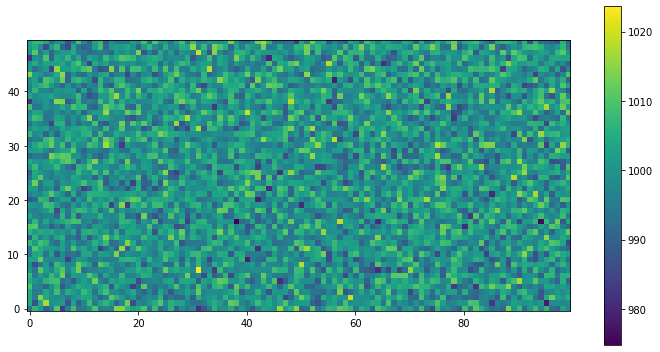

In [7]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1) #행방향 1개, 열방향 1개, 그 중에 첫 번째
im = ax.imshow(bias, origin='lower')
fig.colorbar(im)
plt.tight_layout()

# 3 

In [8]:
np.mean(bias)

1000.139519104005

# 4

In [9]:
bias_hdu = fits.PrimaryHDU(bias.astype('int16'))
bias_hdu.header["BUNIT"] = ("adu", "Pixel Unit Value")
bias_hdu.header["OBJECT"] = ("bias", "The observed target")
bias_hdu.header["EXPTIME"] = (0, '[s] Exposure time')
bias_hdu.header["IMAGETYP"] = ('Bias Frame', 'Type of image')
bias_hdu.header["GAIN"] = (1.36, '[e-/ADU] The electron gain factor.')
bias_hdu.header["RDNOISE"] = (9.0, '[e-] The (Gaussian) read noise.')
bias_hdu.writeto(top/"bias.fits",overwrite=True)

In [10]:
bias_hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100                                                  
NAXIS2  =                   50                                                  
EXTEND  =                    T                                                  
BUNIT   = 'adu     '           / Pixel Unit Value                               
OBJECT  = 'bias    '           / The observed target                            
EXPTIME =                    0 / [s] Exposure time                              
IMAGETYP= 'Bias Frame'         / Type of image                                  
GAIN    =                 1.36 / [e-/ADU] The electron gain factor.             
RDNOISE =                  9.0 / [e-] The (Gaussian) read noise.                

# 5

In [11]:
dark_300s = np.random.poisson(dark_epsec*300, size = final_image.shape)

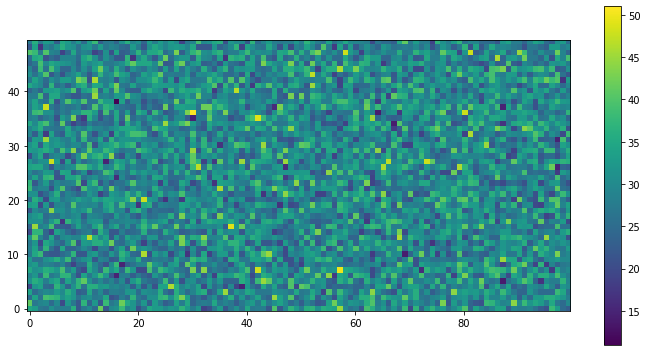

In [12]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
im = ax.imshow(dark_300s, origin='lower')
fig.colorbar(im)
plt.tight_layout()

# 6

In [13]:
dark_300s = add_rdnoise(image_adu=dark_300s/gain_epadu , rdnoise_e=rdnoise_e, gain_epadu=gain_epadu)

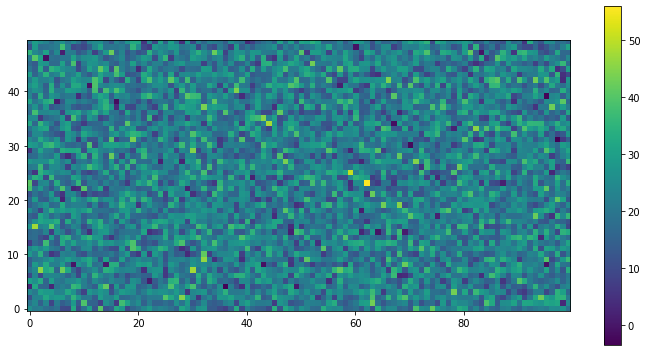

In [14]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
im = ax.imshow(dark_300s, origin='lower')
fig.colorbar(im)
plt.tight_layout()

# 7

In [15]:
np.mean(dark_300s)

22.046253616623538

# 8

In [16]:
dark_hdu = fits.PrimaryHDU(dark_300s.astype('int16'))
dark_hdu.header["BUNIT"] = ('adu', "Pixel Unit Value")
dark_hdu.header["OBJECT"] = ("dark", "The observed target")
dark_hdu.header["EXPTIME"] = (300, '[s] Exposure time')
dark_hdu.header["IMAGETYP"] = ('Dark Frame', 'Type of image')
dark_hdu.header["GAIN"] = (1.36, '[e-/ADU] The electron gain factor.')
dark_hdu.header["RDNOISE"] = (9.0, '[e-] The (Gaussian) read noise.')
dark_hdu.writeto(top/"dark_300.fits",overwrite=True)

In [17]:
dark_hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100                                                  
NAXIS2  =                   50                                                  
EXTEND  =                    T                                                  
BUNIT   = 'adu     '           / Pixel Unit Value                               
OBJECT  = 'dark    '           / The observed target                            
EXPTIME =                  300 / [s] Exposure time                              
IMAGETYP= 'Dark Frame'         / Type of image                                  
GAIN    =                 1.36 / [e-/ADU] The electron gain factor.             
RDNOISE =                  9.0 / [e-] The (Gaussian) read noise.                

# 9

In [18]:
yy,xx = np.mgrid[:final_image.shape[0],:final_image.shape[1]]

In [19]:
print(xx,yy,xx.shape,sep='\n')

[[ 0  1  2 ... 97 98 99]
 [ 0  1  2 ... 97 98 99]
 [ 0  1  2 ... 97 98 99]
 ...
 [ 0  1  2 ... 97 98 99]
 [ 0  1  2 ... 97 98 99]
 [ 0  1  2 ... 97 98 99]]
[[ 0  0  0 ...  0  0  0]
 [ 1  1  1 ...  1  1  1]
 [ 2  2  2 ...  2  2  2]
 ...
 [47 47 47 ... 47 47 47]
 [48 48 48 ... 48 48 48]
 [49 49 49 ... 49 49 49]]
(50, 100)


# 10

In [20]:
print(xx,xx.shape)

[[ 0  1  2 ... 97 98 99]
 [ 0  1  2 ... 97 98 99]
 [ 0  1  2 ... 97 98 99]
 ...
 [ 0  1  2 ... 97 98 99]
 [ 0  1  2 ... 97 98 99]
 [ 0  1  2 ... 97 98 99]] (50, 100)


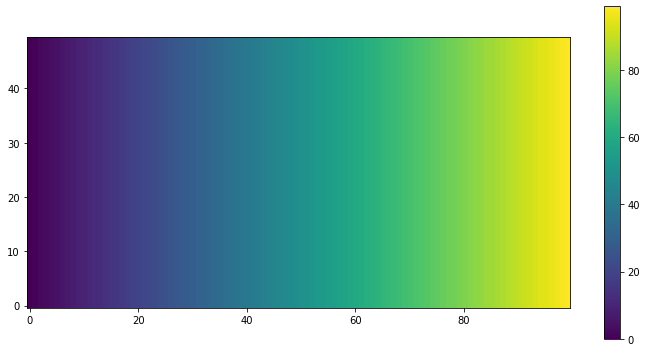

In [21]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1) #행방향 1개, 열방향 1개, 그 중에 첫 번째
im = ax.imshow(xx, origin='lower')
fig.colorbar(im)
plt.tight_layout()

# 11

In [22]:
rsq = (xx - sens_center_xy[0])**2 + (yy - sens_center_xy[1])**2

In [23]:
print(yy,sens_center_xy,rsq.shape,sens_center_xy[0],sens_center_xy[1])

[[ 0  0  0 ...  0  0  0]
 [ 1  1  1 ...  1  1  1]
 [ 2  2  2 ...  2  2  2]
 ...
 [47 47 47 ... 47 47 47]
 [48 48 48 ... 48 48 48]
 [49 49 49 ... 49 49 49]] (90, 30) (50, 100) 90 30


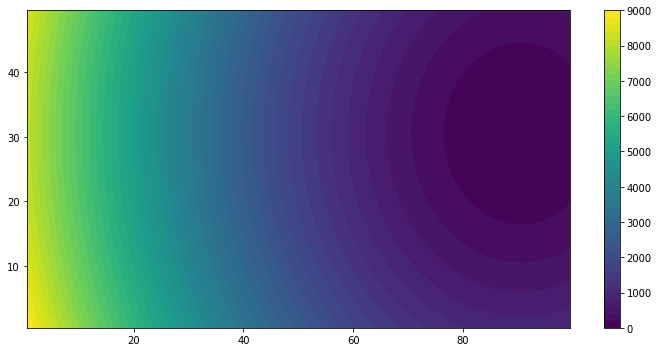

In [24]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1) #행방향 1개, 열방향 1개, 그 중에 첫 번째
im = ax.contourf(rsq, 50 ,origin='lower')
fig.colorbar(im)
plt.tight_layout()

# 12

In [25]:
sens = np.exp(-rsq/(2*sens_sigma)**2)

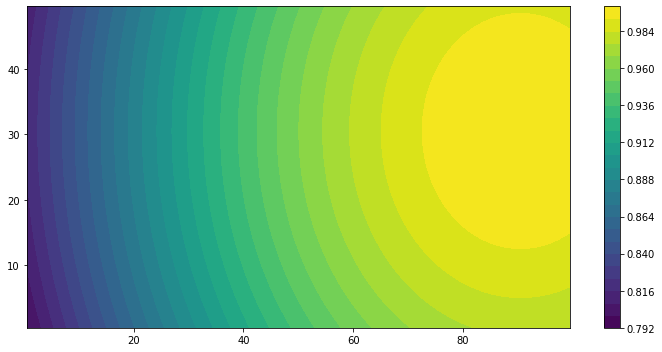

In [26]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
im = ax.contourf(sens, 25 ,origin='lower')
fig.colorbar(im)
plt.tight_layout()

# 13

In [27]:
sens_hdu = fits.PrimaryHDU(sens.astype('float32'))
sens_hdu.header["BUNIT"] = ('dimensionless', "Pixel Unit Value")
sens_hdu.header["OBJECT"] = ("flat", "The observed target")
sens_hdu.header["EXPTIME"] = (300, '[s] Exposure time')
sens_hdu.header["IMAGETYP"] = ('Light Frame', 'Type of image')
sens_hdu.header["GAIN"] = (1.36, '[e-/ADU] The electron gain factor.')
sens_hdu.header["RDNOISE"] = (9.0, '[e-] The (Gaussian) read noise.')
sens_hdu.writeto(top/'flat.fits',overwrite=True)

# 14

I did

# 15

# 16

In [28]:
stars = np.ones_like(final_image) * skylevel_e  # Initialize with sky values
seeing_sigma_pix = seeing_arcsec / pixel_scale

for _, prop in stars_props.items():
    g = IntegratedGaussianPRF(**prop, sigma=seeing_sigma_pix)
    stars += g(xx, yy)  # Add the star to stars
    
stars = np.random.poisson(stars) / gain_epadu  # Poissonian sample and convert to ADU

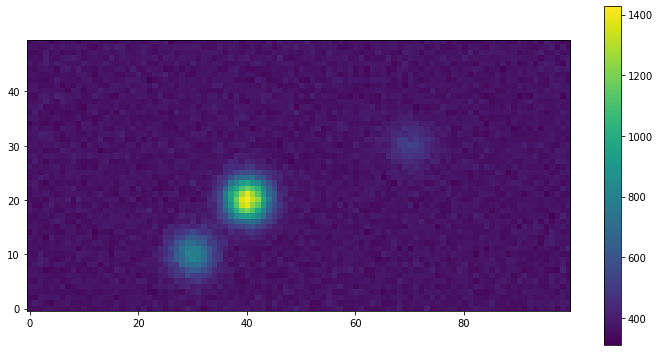

In [29]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
im = ax.imshow(stars, origin='lower')
fig.colorbar(im)
plt.tight_layout()

# 17

In [30]:
nw_bias = np.ones_like(final_image)*bias_adu
#nw_bias = add_rdnoise(image_adu=nw_bias, rdnoise_e=rdnoise_e, gain_epadu=gain_epadu)
nw_dark_300s = np.random.poisson(dark_epsec*300, size = final_image.shape)
#nw_dark_300s = add_rdnoise(image_adu=nw_dark_300s/gain_epadu , rdnoise_e=rdnoise_e, gain_epadu=gain_epadu)
stars_adu = nw_bias + nw_dark_300s/gain_epadu + sens*stars
stars_adu = add_rdnoise(image_adu=stars_adu, rdnoise_e=rdnoise_e, gain_epadu=gain_epadu)

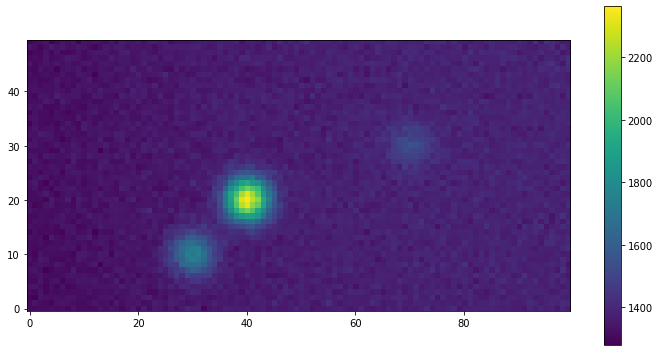

In [31]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
im = ax.imshow(stars_adu, origin='lower')
fig.colorbar(im)
plt.tight_layout()

# 18

In [32]:
stars_hdu = fits.PrimaryHDU(stars_adu.astype('int16'))
stars_hdu.header["BUNIT"] = ('adu', "Pixel Unit Value")
stars_hdu.header["OBJECT"] = ('stars', "The observed target")
stars_hdu.header["EXPTIME"] = (300, '[s] Exposure time')
stars_hdu.header["IMAGETYP"] = ('Light Frame', 'Type of image')
stars_hdu.header["GAIN"] = (1.36, '[e-/ADU] The electron gain factor.')
stars_hdu.header["RDNOISE"] = (9.0, '[e-] The (Gaussian) read noise.')
stars_hdu.writeto(top/'image0001.fits',overwrite=True)

# 19

In [33]:
master_paths = dict(bias=top/"bias.fits",
                       dark=top/"dark_300.fits",
                       flat=top/"flat.fits")
master_frames = {}
for k, v in master_paths.items():
    master_frames[k] = fits.open(v)[0]

rawim = fits.open(top/"image0001.fits")[0]

# 20

In [34]:
hdr = rawim.header.copy()
try: 
    _ = hdr["PROCESS"]
except KeyError:
    hdr["PROCESS"] = ''

# Bias subtraction
rawim_reduced = rawim.data - master_frames['bias'].data
hdr["PROCESS"] += "B"
hdr.add_history(f"Bias subtracted by {master_paths['bias']}")
                
hdu = fits.PrimaryHDU(data=rawim_reduced, header=hdr)
hdu.writeto(top/"image0001_bxx.fits", overwrite=True)
                
# Dark subtraction
#   NOTE: our dark is already bias subtracted!
dark_exptime = master_frames['dark'].header['EXPTIME']
targ_exptime = hdr['EXPTIME']
dark = master_frames['dark'].data
if targ_exptime == dark_exptime:
    rawim_reduced = rawim_reduced - dark
else:
    print("No corresponding dark frame found; "
          + f"Scaling it from {dark_exptime}.")
    rawim_reduced = rawim_reduced - dark * (targ_exptime/dark_exptime)
hdr["PROCESS"] += "D"
hdr.add_history(f"Dark subtracted by {master_paths['dark']}")

hdu = fits.PrimaryHDU(data=rawim_reduced, header=hdr)
hdu.writeto(top/"image0001_bdx.fits", overwrite=True)

# Flat correction
#   NOTE: our flat is already bias and dark subtracted!
flat_mean = np.mean(master_frames['flat'].data)
flat_norm = master_frames['flat'].data / flat_mean
rawim_reduced = rawim_reduced / flat_norm
hdr["PROCESS"] += "F"
hdr.add_history(f"Flat corrected by {master_paths['flat']} (flat mean={flat_mean})")

hdu = fits.PrimaryHDU(data=rawim_reduced.astype('float32'), header=hdr)
hdu.writeto(top/"image0001_bdf.fits", overwrite=True)

In [35]:
print(hdr['history'], hdr["PROCESS"],sep='\n')

Bias subtracted by tmp\bias.fits
Dark subtracted by tmp\dark_300.fits
Flat corrected by tmp\flat.fits (flat mean=0.9361974596977234)
BDF


In [36]:
hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100                                                  
NAXIS2  =                   50                                                  
BUNIT   = 'adu     '           / Pixel Unit Value                               
OBJECT  = 'stars   '           / The observed target                            
EXPTIME =                  300 / [s] Exposure time                              
IMAGETYP= 'Light Frame'        / Type of image                                  
GAIN    =                 1.36 / [e-/ADU] The electron gain factor.             
RDNOISE =                  9.0 / [e-] The (Gaussian) read noise.                
PROCESS = 'BDF     '                                                            
HISTORY Bias subtracted by t

# 21

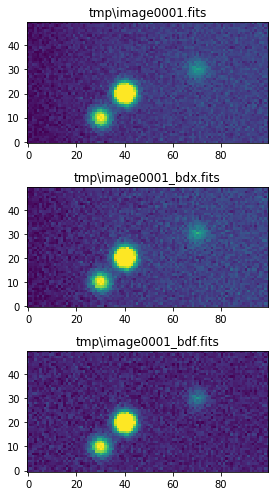

In [37]:
fig, axs = plt.subplots(3, 1, figsize=(6, 7), sharex=False, sharey=False, gridspec_kw=None)

for i, fpath in enumerate([top/"image0001.fits", 
                           top/"image0001_bdx.fits", 
                           top/"image0001_bdf.fits"]):
    data = fits.getdata(fpath)
    vmin, vmax = np.percentile(data, [1, 99]) # 1~99% 사이만 나타내고 그 밖은 버림
    axs[i].imshow(data, origin='lower', vmin=vmin, vmax=vmax)
    axs[i].set(title=fpath)
plt.tight_layout()
plt.show()

# 22

In [38]:
i = fits.open(top/'bias.fits')[0]
i = fits.open(top/'bias.fits')
i.close()

master_paths = dict(bias=top/"bias.fits",
                       dark=top/"dark_300.fits",
                       flat=top/"flat.fits")
master_frames = {}
for k, v in master_paths.items():
    master_frames[k] = fits.open(v)
    master_frames[k].close()

rawim = fits.open(top/"image0001.fits")
rawim.close()
data = fits.open(top/"image0001.fits")
data.close()

dark_exptime = fits.open(top/"dark_300.fits")
dark_exptime.close()
dark=fits.open(top/"dark_300.fits")
dark.close()
targ_exptime =fits.open(top/"dark_300.fits")
targ_exptime.close()

dark_exptime = fits.open(top/"dark_300.fits")
dark_exptime.close()
dark=fits.open(top/"dark_300.fits")
dark.close()
targ_exptime =fits.open(top/"dark_300.fits")
targ_exptime.close()



In [39]:
for i in list(top.glob('*.fits')):
    try:
        i.unlink()
    except:
        continue

# 23

109997.83238983617 109997.64757460186


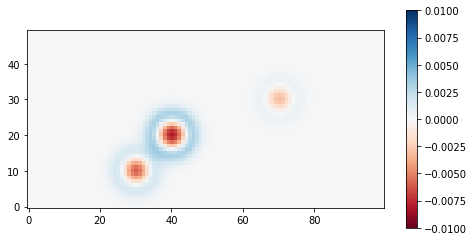

In [40]:
# Here, no noise will be added, because the purpose is to see the difference 
# (between Integrated PRF and simple Gaussian function value)


stars_psf = np.zeros_like(final_image)  # Simple function value case
stars_int = np.zeros_like(final_image)  # Integrated value case

seeing_sigma_pix = seeing_arcsec / pixel_scale
seeing = dict(x_stddev=seeing_sigma_pix, y_stddev=seeing_sigma_pix)    

for _, prop in stars_props.items():
    amp = prop["flux"] / (2*np.pi * seeing_sigma_pix**2)
    g_psf = Gaussian2D(amplitude=amp, 
                       x_mean=prop['x_0'], 
                       y_mean=prop['y_0'], 
                       **seeing)
    g_int = IntegratedGaussianPRF(**prop, sigma=seeing_sigma_pix)
    stars_psf += g_psf(xx, yy)
    stars_int += g_int(xx, yy)
    
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
diff = (stars_int - stars_psf) / (stars_int + skylevel_e)  

im = axs.imshow(diff, origin='lower', vmin=-0.01, vmax=0.01, cmap='RdBu')
plt.colorbar(im)
print(np.sum(stars_psf), np.sum(stars_int))

# 24

skylevel electrons: min difference, max difference
                 0:   -1.08341   %,    6.26159   %
               200:   -0.95035   %,    0.69445   %
               400:   -0.84640   %,    0.42502   %
               600:   -0.76295   %,    0.30621   %
               800:   -0.69448   %,    0.23932   %


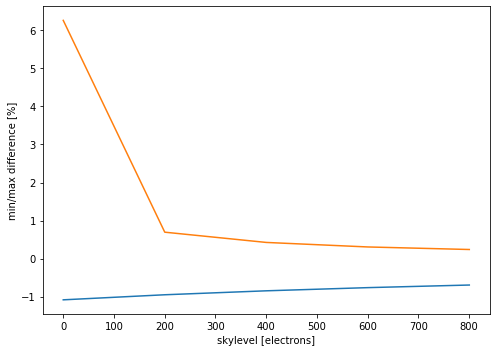

In [41]:
# Here, no noise will be added, because the purpose is to see the difference 
# (between Integrated PRF and simple Gaussian function value)
seeing_sigma_pix = seeing_arcsec / pixel_scale
seeing = dict(x_stddev=seeing_sigma_pix, y_stddev=seeing_sigma_pix)

mins = []
maxs = []
skylevels = np.arange(0.1, 1000, 200)

print("skylevel electrons: min difference, max difference")
for skylevel in skylevels:
    stars_psf = np.zeros_like(final_image)  # Simple function value case
    stars_int = np.zeros_like(final_image)  # Integrated value case
    for _, prop in stars_props.items():
        amp = prop["flux"] / (2*np.pi * seeing_sigma_pix**2)
        g_psf = Gaussian2D(amplitude=amp, 
                           x_mean=prop['x_0'], 
                           y_mean=prop['y_0'], 
                           **seeing)
        g_int = IntegratedGaussianPRF(**prop, sigma=seeing_sigma_pix)
        stars_psf += g_psf(xx, yy)
        stars_int += g_int(xx, yy)
    diff = (stars_int - stars_psf) / (stars_int + skylevel)  
    vmin = 100*np.min(diff)
    vmax = 100*np.max(diff)
    mins.append(vmin)
    maxs.append(vmax)
    print("{:18.0f}: {:^13.5f}%, {:^13.5f}%".format(skylevel, vmin, vmax))

fig, axs = plt.subplots(1, 1, figsize=(7, 5))
axs.plot(skylevels, mins)
axs.plot(skylevels, maxs)
axs.set(xlabel='skylevel [electrons]', ylabel='min/max difference [%]')
plt.tight_layout()
plt.show()